### Installing Transformers as would be used


In [1]:
!pip install transformers -U

### The compressed data is read. [Here](https://www.kaggle.com/datasets/bittlingmayer/amazonreviews/data) is the Amazon dataset used

In [1]:
import pandas as pd

import bz2

def decompress_bz2(file_path, output_path):
    with bz2.open(file_path, 'rt', encoding='utf-8') as file:
        with open(output_path, 'w', encoding='utf-8') as out_file:
            out_file.write(file.read())

# Decompress the files
decompress_bz2('train.ft.txt.bz2', 'train.ft.txt')

### The data is now analysed to see its shape, properties and size

In [2]:
def parse_data(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            label, text = line.split(' ', 1)
            label = int(label.replace('__label__', ''))
            data.append((label, text.strip()))
    return pd.DataFrame(data, columns=['label', 'text'])

In [3]:
train = parse_data('train.ft.txt')

train

,label,text
0,2,Stuning even for the non-gamer: This sound tra...
1,2,The best soundtrack ever to anything.: I'm rea...
2,2,Amazing!: This soundtrack is my favorite music...
3,2,Excellent Soundtrack: I truly like this soundt...
4,2,"Remember, Pull Your Jaw Off The Floor After He..."
...,...,...
3599995,1,Don't do it!!: The high chair looks great when...
3599996,1,"Looks nice, low functionality: I have used thi..."
3599997,1,"compact, but hard to clean: We have a small ho..."
3599998,1,what is it saying?: not sure what this book is...


In [25]:
# Only two unique classes are used as targets
train['label'].unique()

array([2, 1], dtype=int64)

In [4]:
#They are mapped from [2,1] to [1,0]
df = train.copy()
df.label = df.label.map({2:0, 1:1})  # 1 are negatives (targeted class)
df

,label,text
0,0,Stuning even for the non-gamer: This sound tra...
1,0,The best soundtrack ever to anything.: I'm rea...
2,0,Amazing!: This soundtrack is my favorite music...
3,0,Excellent Soundtrack: I truly like this soundt...
4,0,"Remember, Pull Your Jaw Off The Floor After He..."
...,...,...
3599995,1,Don't do it!!: The high chair looks great when...
3599996,1,"Looks nice, low functionality: I have used thi..."
3599997,1,"compact, but hard to clean: We have a small ho..."
3599998,1,what is it saying?: not sure what this book is...


In [5]:
# We're going to use only 10000 records from the data for faster training
df = df[0:10000]
df

,label,text
0,0,Stuning even for the non-gamer: This sound tra...
1,0,The best soundtrack ever to anything.: I'm rea...
2,0,Amazing!: This soundtrack is my favorite music...
3,0,Excellent Soundtrack: I truly like this soundt...
4,0,"Remember, Pull Your Jaw Off The Floor After He..."
...,...,...
9995,0,A revelation of life in small town America in ...
9996,0,Great biography of a very interesting journali...
9997,1,Interesting Subject; Poor Presentation: You'd ...
9998,1,Don't buy: The box looked used and it is obvio...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   10000 non-null  int64 
 1   text    10000 non-null  object
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


label
1    5097
0    4903
Name: count, dtype: int64


<Axes: xlabel='label'>

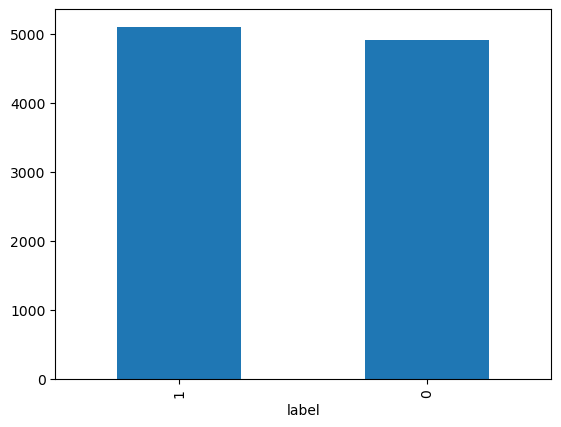

In [7]:
# Data is balanced
print(df['label'].value_counts())
df['label'].value_counts().plot(kind='bar')

In [11]:
pip install transformers


  Using cached transformers-4.45.2-py3-none-any.whl.metadata (44 kB)
  Using cached safetensors-0.4.5-cp311-none-win_amd64.whl.metadata (3.9 kB)
  Using cached tokenizers-0.20.1-cp311-none-win_amd64.whl.metadata (6.9 kB)
Using cached transformers-4.45.2-py3-none-any.whl (9.9 MB)
Using cached safetensors-0.4.5-cp311-none-win_amd64.whl (285 kB)
Using cached tokenizers-0.20.1-cp311-none-win_amd64.whl (2.4 MB)


## Importing the necessary training modules and metrics

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import torch
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification

In [9]:
from transformers import BertTokenizer, BertForSequenceClassification
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
X = list(df["text"])
y = list(df["label"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y)

X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

## Pytorch

In [11]:
# Converting X and y into Pytorch Dataset (as transformers accept data in that format)

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

# This method is used to retrieve a single sample from the dataset.
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])


In [12]:
train_dataset = Dataset(X_train_tokenized, y_train)
test_dataset = Dataset(X_test_tokenized, y_test)

In [13]:
train_dataset[3]

{'input_ids': tensor([  101,  1037,  3969,  2732,  2002,  2003,  1024,  2023,  2201,  2003,
          2061,  2214,  2082,  1999,  2049,  3082,  7294, 10299,  1012,  1045,
          1005,  1049, 23042,  1012,  2045,  2003,  2498,  6517,  2006,  2023,
          2201,  1006,  3272,  2005,  1996,  2200,  3809,  2299,  3336, 18938,
          5886,  1063,  2055,  3352,  2019, 16655,  2595,  5051, 25572,  3372,
          2269,  1065,  1007,  1012,  2009,  1005,  1055,  1037,  2514,  2204,
          3729,  1012,  2130,  1996,  2681, 14074, 11488,  3351,  2650,  2003,
          4569,  1012,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [14]:
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [21]:
pip install transformers[torch]



   ---------------------------------------- 0.0/330.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/330.9 kB ? eta -:--:--
   --- ----------------------------------- 30.7/330.9 kB 660.6 kB/s eta 0:00:01
   --- ----------------------------------- 30.7/330.9 kB 660.6 kB/s eta 0:00:01
   ------- ------------------------------- 61.4/330.9 kB 328.2 kB/s eta 0:00:01
   ---------- ---------------------------- 92.2/330.9 kB 403.5 kB/s eta 0:00:01
   -------------- ----------------------- 122.9/330.9 kB 481.4 kB/s eta 0:00:01
   -------------- ----------------------- 122.9/330.9 kB 481.4 kB/s eta 0:00:01
   ------------------- ------------------ 174.1/330.9 kB 477.7 kB/s eta 0:00:01
   ----------------------------- -------- 256.0/330.9 kB 630.2 kB/s eta 0:00:01
   -------------------------------- ----- 286.7/330.9 kB 655.2 kB/s eta 0:00:01
   -------------------------------------  327.7/330.9 kB 655.9 kB/s eta 0:00:01
   -------------------------------------- 330.9/330.9 kB 

In [23]:
pip install accelerate>=0.26.0

Note: you may need to restart the kernel to use updated packages.


In [15]:
# Define Trainer

args = TrainingArguments(
    output_dir="output",
    num_train_epochs=1,
    per_device_train_batch_size=8

)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

In [16]:
trainer.train()

Step,Training Loss
500,0.319400
1000,0.235000


TrainOutput(global_step=1000, training_loss=0.27717655181884765, metrics={'train_runtime': 38829.6421, 'train_samples_per_second': 0.206, 'train_steps_per_second': 0.026, 'total_flos': 1537555229760000.0, 'train_loss': 0.27717655181884765, 'epoch': 1.0})

In [17]:
trainer.evaluate()

{'eval_loss': 0.21620133519172668,
 'eval_accuracy': 0.9335,
 'eval_precision': 0.9267822736030829,
 'eval_recall': 0.9440628066732091,
 'eval_f1': 0.9353427321341761,
 'eval_runtime': 1145.1118,
 'eval_samples_per_second': 1.747,
 'eval_steps_per_second': 0.218,
 'epoch': 1.0}

In [20]:
def classify_text(text, model, tokenizer):
    # Check if CUDA is available, otherwise fallback to CPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Tokenize the input text and move it to the selected device (CPU or GPU)
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors='pt').to(device)
    
    # Move the model to the selected device
    model = model.to(device)
    
    # Get model outputs
    outputs = model(**inputs)
    
    # Apply softmax to the logits to get probabilities
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    
    # Move the predictions back to CPU and convert to numpy array (if needed)
    predictions = predictions.cpu().detach().numpy()
    
    # Print the predictions
    print(predictions)
    
    # Check the first index and print the corresponding label
    if predictions[0][0] > 0.5:
        print("Positive")
    else:
        print("Negative")
    
    return predictions

# Example call to classify text
predictions = classify_text("The mobile is awesome", model, tokenizer)


[[0.996407   0.00359302]]
Positive


In [21]:
predictions = classify_text("The mobile is bad", model, tokenizer)

[[0.0022754 0.9977246]]
Negative


In [22]:
predictions = classify_text("""After purchasing such an expensive item we do not expect such damaged item box. 
The box was damaged in various places and had tape applied on the front. I don't know whether the damage was
due to the box falling or not. I am also confused whether the box and PS5 might have suffered any damage due to the fall. 
I am not satisfied. You have to give proper box packing without any damage.""", model, tokenizer)

[[0.00408918 0.9959109 ]]
Negative
